# HAB Capstone Wrangling 2 - GLERL Data

The Great Lakes Environmental Research Laboratory (GLERL) and the Cooperative Institute for Great Lakes Research collect water quality data in western Lake Erie in order to monitor the potential for Harmful Algal Blooms (HAB). Lake Erie is the shallowest of the Great Lakes, so it tends to reach higher temperatures, and runoff or river deposition of chemicals such as nitrogen- and phosphorus-containing compounds has a greater impact on its water quality. Warm temperatures, nitrogen, and phosphorus are favorable conditions for the growth of phytoplankton, algae, and cyanobacteria. Although not all algae are problematic, HABs have detrimental effects due to the toxins that they release, of which the most common is microcystin. Beginning in 2012 GLERL began weekly sampling trips to collect water quality data, including microcystin levels, before, during, and after HAB events. Some of these collections were performed by boat or automated, movable buoys. Moored buoy station locations were eventually established starting in 2014. The original data can be accessed through NOAA's National Centers for Environmental Information Database <a href='https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.nodc:GLERL-CIGLR-HAB-LakeErie-water-qual'>here</a>.

In [1]:
import datetime as dt
import folium
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
import os
import pandas as pd
import re
import seaborn

The raw data has already been cleaned and the data from 2012-2018 merged with the data from 2019 (see HAB_Capstone_Data_Wrangling.ipynb). Outliers were examined and determined to likely be good data in that document, since the nature of algal blooms is that environmental factors result in extreme events over possibly short periods of time and spatial extents.

In [2]:
df_glerl = pd.read_csv('../data/interim/glerl_merged.csv', parse_dates=['Date'], index_col=0)
df_glerl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1427 entries, 0 to 1462
Data columns (total 33 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           1427 non-null   datetime64[ns]
 1   Site                                                           1427 non-null   object        
 2   Station Depth (m)                                              990 non-null    float64       
 3   Sample Depth (m)                                               1410 non-null   float64       
 4   Sample Depth (category)                                        1427 non-null   object        
 5   Local Time (Eastern Time Zone)                                 1000 non-null   object        
 6   Latitude (decimal deg)                                         1427 non-null   float64       
 7

## Categorical Variables
### Sites

In [3]:
df_glerl['Site'].value_counts()

WE2           241
WE8           241
WE13          217
WE12          208
WE6           160
WE4           151
WE9            80
WE15           51
WE16           31
WE14           15
WE 2013.6       1
WE 2012.3       1
WE 2013.15      1
WE 2013.11      1
WE 2013.4       1
1-Aug           1
WE 2013.1       1
WE 2013.7       1
2017.2          1
2019.1          1
2017.3          1
WE 2013.5       1
2017.1          1
WE 2012.2       1
WE 2013.8       1
WE 2012.6       1
WE 2012.5       1
WE 2012.1       1
WE 2013.3       1
WE 2013.19      1
WE 2013.9       1
2-Aug           1
WE 2013.10      1
WE 2012.4       1
WE 2013.14      1
WE 2013.18      1
WE 2013.16      1
WE 2012.7       1
2019.2          1
WE 2013.17      1
WE 2013.2       1
WE 2013.12      1
Name: Site, dtype: int64

The stations with WE# names are known water quality stations, some of which are still active and can be found at the Great Lakes Observing System website <a html='https://glbuoys.glos.us/erie'>here</a>. The remaining 'sites' are likely entry errors involving the date.

In [4]:
sites = ['WE2', 'WE8', 'WE13', 'WE12', 'WE6', 
         'WE4', 'WE9', 'WE15', 'WE16', 'WE14']
df_glerl[~df_glerl['Site'].apply(lambda s: s in sites)]

,Date,Site,Station Depth (m),Sample Depth (m),Sample Depth (category),Local Time (Eastern Time Zone),Latitude (decimal deg),Longitude (decimal deg),Wind speed (knots),Wave Height (ft),...,Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Soluble Reactive Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),Particulate Organic Carbon (mg/L),Particulate Organic Nitrogen (mg/L),Colored Dissolved Organic Material absorbance (m-1) at 400nm,Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L)
118,2019-08-05,2019.1,NaN,0.00,Scum,12:14,41.7075,-83.3761,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,2019-08-19,2019.2,NaN,0.00,Scum,12:40,41.7395,-83.3711,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2012-07-31,WE 2012.1,3.1,0.75,Surface,13:20,41.6315,-83.1521,NaN,NaN,...,20.94,4.36,0.25,0.04,0.389,1.07,0.15,NaN,NaN,NaN
247,2012-07-31,WE 2012.2,9.0,0.75,Surface,13:50,41.7394,-83.1144,NaN,NaN,...,30.41,10.61,3.22,0.04,0.405,0.82,0.16,NaN,NaN,NaN
248,2012-07-31,WE 2012.3,8.4,0.75,Surface,14:12,41.7960,-83.1675,NaN,NaN,...,NaN,4.25,0.25,0.04,0.405,1.19,0.18,NaN,NaN,NaN
253,2012-08-06,WE 2012.4,5.8,0.75,Surface,10:25,41.8361,-83.3373,NaN,NaN,...,60.64,7.52,0.44,0.23,0.434,3.81,0.81,NaN,NaN,NaN
262,2012-08-20,WE 2012.5,2.8,0.75,Surface,11:50,41.7039,-83.3860,NaN,NaN,...,84.18,14.60,0.92,3.47,0.123,4.84,0.94,NaN,NaN,NaN
271,2012-09-05,WE 2012.6,5.5,0.75,Surface,11:00,41.4833,-82.6983,NaN,NaN,...,99.69,25.54,16.58,0.82,0.002,3.46,0.61,NaN,NaN,NaN
272,2012-09-05,WE 2012.7,5.0,0.75,Surface,11:54,41.5606,-82.9072,NaN,NaN,...,23.41,13.04,7.69,6.66,0.005,0.65,0.14,NaN,NaN,NaN
309,2013-07-15,WE 2013.1,5.9,0.75,Surface,11:57,41.8330,-83.3220,NaN,NaN,...,161.79,10.86,1.87,1.73,2.139,11.15,1.98,NaN,24.60,21.18


These sites seem to be erroneous, and since each site has different latitudes and longitudes they cannot be reassigned to the correct site. Instead they will be renamed "unknown."

In [5]:
df_glerl.loc[~df_glerl['Site'].apply(lambda s: s in sites), 'Site'] = 'Unknown'

In [6]:
df_glerl['Site'].value_counts()

WE2        241
WE8        241
WE13       217
WE12       208
WE6        160
WE4        151
WE9         80
WE15        51
Unknown     32
WE16        31
WE14        15
Name: Site, dtype: int64

#### Mapping sites

In [7]:
#aggregate by coordinate combination so that there are not repeat tokens on the map
coords = df_glerl.groupby(['Latitude (decimal deg)','Longitude (decimal deg)']).agg({'Site': 'first', 'Date': 'count'}).rename(columns={'Date': 'Counts'}).reset_index()
coords.sort_values('Counts', ascending=False).head()


,Latitude (decimal deg),Longitude (decimal deg),Site,Counts
521,41.7447,-83.1348,WE13,6
177,41.7040,-83.2528,WE12,6
2,41.2633,-83.3290,WE2,6
480,41.7428,-83.1350,WE13,6
878,41.8341,-83.3553,WE8,6


In [8]:
m = folium.Map(location=[41.76, -83.26])
for i in coords.index:
    lat = coords.loc[i, 'Latitude (decimal deg)']
    long = coords.loc[i, 'Longitude (decimal deg)']
    site = coords.loc[i,'Site']
    counts = coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts)).add_to(m)
m

We can clearly see the clusters around the moored stations, some of which have more measurements than others (see Methods - Study Area of <a href='https://www.sciencedirect.com/science/article/pii/S038013301930067X'>Sayers et al</a>). There are also clearly some errors here with the points that are found on land. We can remove them by dropping any points with latitudes <=41.3592 or >=42.002, and longitudes <=-83.5683.

In [9]:
bad_coords = (df_glerl['Latitude (decimal deg)'] <= 41.3592) | (df_glerl['Latitude (decimal deg)'] >= 42.002) | (df_glerl['Longitude (decimal deg)'] <= -83.5683)
df_glerl = df_glerl[~bad_coords].copy()

In [10]:
#check that all errant coordinates were removed
coords = df_glerl.groupby(['Latitude (decimal deg)','Longitude (decimal deg)']).agg({'Site': 'first', 'Date': 'count'}).rename(columns={'Date': 'Counts'}).reset_index()
m = folium.Map(location=[41.76, -83.26])
for i in coords.index:
    lat = coords.loc[i, 'Latitude (decimal deg)']
    long = coords.loc[i, 'Longitude (decimal deg)']
    site = coords.loc[i,'Site']
    counts = coords.loc[i, 'Counts']
    folium.Marker([lat, long], popup=(lat,long), tooltip=(site, counts)).add_to(m)
m

In [11]:
#Taking a closer look at the Sandusky point, there is only one measurement here and it is far removed from our other 
#data, so it will be dropped.
df_glerl.drop(index=263, inplace=True)

### Sample Depth

In [12]:
df_glerl['Sample Depth (category)'].value_counts()

Surface       987
Bottom        356
Scum           47
Mid-column     19
Name: Sample Depth (category), dtype: int64

Most (~70%) of the samples are from the surface, ~25% are bottom samples, and the remaining are mid-column and scum samples. For the purpose of investigating algae formation surface samples are the most relevant, since algal blooms tend to form at the surface of the water. Let's examine the bottom samples.

In [13]:
df_glerl[df_glerl['Sample Depth (category)'] == 'Bottom'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356 entries, 1 to 1459
Data columns (total 33 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           356 non-null    datetime64[ns]
 1   Site                                                           356 non-null    object        
 2   Station Depth (m)                                              0 non-null      float64       
 3   Sample Depth (m)                                               355 non-null    float64       
 4   Sample Depth (category)                                        356 non-null    object        
 5   Local Time (Eastern Time Zone)                                 1 non-null      object        
 6   Latitude (decimal deg)                                         356 non-null    float64       
 7 

In [14]:
df_glerl[df_glerl['Sample Depth (category)'] == 'Mid-column'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 514 to 757
Data columns (total 33 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           19 non-null     datetime64[ns]
 1   Site                                                           19 non-null     object        
 2   Station Depth (m)                                              0 non-null      float64       
 3   Sample Depth (m)                                               19 non-null     float64       
 4   Sample Depth (category)                                        19 non-null     object        
 5   Local Time (Eastern Time Zone)                                 0 non-null      object        
 6   Latitude (decimal deg)                                         19 non-null     float64       
 7 

In [15]:
df_glerl[df_glerl['Sample Depth (category)'] == 'Scum'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47 entries, 107 to 1234
Data columns (total 33 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           47 non-null     datetime64[ns]
 1   Site                                                           47 non-null     object        
 2   Station Depth (m)                                              0 non-null      float64       
 3   Sample Depth (m)                                               31 non-null     float64       
 4   Sample Depth (category)                                        47 non-null     object        
 5   Local Time (Eastern Time Zone)                                 5 non-null      object        
 6   Latitude (decimal deg)                                         47 non-null     float64       
 7

Most of the non-surface samples contain the target microcystin data, but they are almost all missing chemical water quality data. This presents the question of whether to drop or retain the non-surface samples - although they do not have the data that would most likely be used to predict HAB presence, the microcystin values could be used to categorize a given location at a given date as meeting the requirements for a HAB. For now they will be saved in a separate data frame and we will continue to examine surface samples only.

In [16]:
non_surface = df_glerl[df_glerl['Sample Depth (category)'] != 'Surface'].copy().reset_index(drop=True)
surface = df_glerl[df_glerl['Sample Depth (category)'] == 'Surface'].copy().reset_index(drop=True)

### Sky

In [17]:
surface['Sky'].value_counts()

sunny                444
cloudy               214
mostly sunny          60
partly sunny          52
mostly cloudy         48
partly cloudy         36
overcast              20
clear                 19
rainy                 14
hazy                  13
rain                  12
foggy                  9
Partly Sunny           4
cloudy, rainy          2
sunny/hazy             2
Cloudy                 2
mosty sunny            2
cloudy/rain            2
mosly sunny            2
hazy/sunny             2
hazy/clear             1
Partly Cloudy          1
cloudy/rainy           1
0.059027778            1
cloudy/little fog      1
coudy                  1
foggy but sunny        1
sunny but foggy        1
Name: Sky, dtype: int64

In [18]:
#merge some similar terms and deal with typos
surface['Sky'] = surface['Sky'].astype('str').apply(lambda s: s.lower())
surface.loc[surface['Sky'] == 'mosty sunny', 'Sky'] = 'mostly sunny'
surface.loc[surface['Sky'] == 'mosly sunny', 'Sky'] = 'mostly sunny'
surface.loc[surface['Sky'].str.contains('rain'), 'Sky'] = 'rainy'
surface.loc[surface['Sky'].str.contains('hazy'), 'Sky'] = 'hazy'
surface.loc[surface['Sky'].str.contains('foggy'), 'Sky'] = 'foggy'
surface.loc[surface['Sky'] == 'coudy', 'Sky'] = 'cloudy'
surface.loc[surface['Sky'] == 'cloudy/little fog', 'Sky'] = 'cloudy'
surface.loc[surface['Sky'] == '0.059027778', 'Sky'] = np.nan

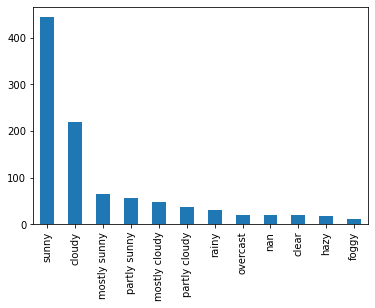

In [19]:
surface['Sky'].value_counts().plot.bar()

## Date Distribution and Completeness

Let's take a look at the date distribution of the GLERL data by grouping by month and aggregating by measurement count for each quantity. The 'Site' column provides the total counts since it contains no null data. We can use it as a comparison for other quantities that do have some null entries.

In [20]:
def resampled_counts(df, datecol, resample='M', cols=None, figsize=(15,3),
                       title=None, width=15, alpha=0.5, subplots=False, fcn='count'):
    
    ''' Resamples a dataframe over a given timeframe, and plots counts of the columns as 
    overlapping bar charts. The datecol input must contain datetimes. The cols parameter 
    should be a list of columns. Can aggregate using a different function by setting the fcn parameter'''
    
    dfc = df.resample(resample, on=datecol).agg(fcn)
    idx = dfc.index
    if cols == None:
        cols = df.columns
    fig, ax = plt.subplots(figsize=figsize)
    for i, col in enumerate(cols):
        ax.bar(idx, dfc[col], width=width, alpha=alpha, label=col, 
               color='C{0}'.format(i))
    ax.xaxis_date()
    ax.set_xlabel('Date')
    ax.set_ylabel('Measurement Counts')
    ax.legend(loc='best')
    ax.set_title(title)

In [21]:
we2 = surface[surface['Site'] == 'WE2']
we2.head()

,Date,Site,Station Depth (m),Sample Depth (m),Sample Depth (category),Local Time (Eastern Time Zone),Latitude (decimal deg),Longitude (decimal deg),Wind speed (knots),Wave Height (ft),...,Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Soluble Reactive Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),Particulate Organic Carbon (mg/L),Particulate Organic Nitrogen (mg/L),Colored Dissolved Organic Material absorbance (m-1) at 400nm,Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L)
0,2019-04-30,WE2,5.90,0.75,Surface,11:41,41.7634,-83.3302,NaN,NaN,...,330.67,81.72,77.04,54.25,2.550,5.53,0.77,4.48,172.40,20.60
4,2019-05-21,WE2,6.11,0.75,Surface,13:33,41.7625,-83.3287,7.00,NaN,...,118.23,74.06,68.36,55.36,2.799,1.20,0.22,4.26,33.40,2.35
12,2019-06-03,WE2,6.06,0.75,Surface,13:43,41.7626,-83.3290,4.40,0.68,...,42.29,8.03,6.20,23.82,0.958,1.34,0.21,1.38,10.37,3.11
20,2019-06-17,WE2,5.84,0.75,Surface,12:32,41.7633,-83.3300,3.32,1.36,...,161.74,103.01,84.03,52.70,2.313,1.05,0.17,4.19,37.31,3.61
28,2019-07-01,WE2,6.00,0.75,Surface,12:52,41.7625,-83.3293,9.69,0.54,...,67.33,14.48,3.59,3.91,1.385,1.94,0.29,2.68,8.02,4.41


In [22]:
we2.columns

Index(['Date', 'Site', 'Station Depth (m)', 'Sample Depth (m)',
       'Sample Depth (category)', 'Local Time (Eastern Time Zone)',
       'Latitude (decimal deg)', 'Longitude (decimal deg)',
       'Wind speed (knots)', 'Wave Height (ft)', 'Sky', 'Secchi Depth (m)',
       'CTD Temperature (°C)', 'CTD Specific Conductivity (µS/cm)',
       'CTD Beam Attenuation (m-1)', 'CTD Tramission (%)',
       'CTD Dissolved Oxygen (mg/L)',
       'CTD Photosynthetically Active Radiation (µE/m2/s)', 'Turbidity (NTU)',
       'Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)',
       'Extracted Phycocyanin (µg/L)', 'Extracted Chlorophyll a (µg/L)',
       'Total Phosphorus (µg P/L)', 'Total Dissolved Phosphorus (µg P/L)',
       'Soluble Reactive Phosphorus (µg P/L)', 'Ammonia (µg N/L)',
       'Nitrate + Nitrite (mg N/L)', 'Particulate Organic Carbon (mg/L)',
       'Particulate Organic Nitrogen (mg/L)',
       'Colored Dissolved Organic Material absorbance (m-1) at 400nm ',
       '

In [23]:
we2['Date'].dt.dayofweek.value_counts()

0    100
1     29
2      9
3      4
4      1
Name: Date, dtype: int64

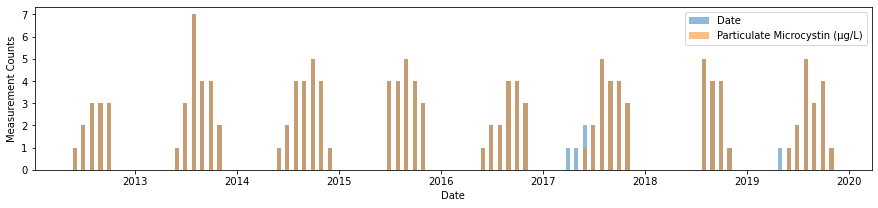

In [24]:
resampled_counts(we2, 'Date', cols=['Date', 'Particulate Microcystin (µg/L)'])

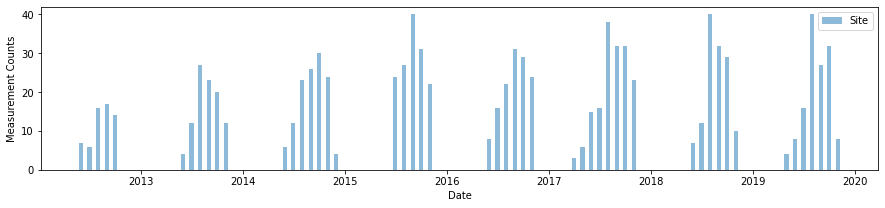

In [25]:
resampled_counts(surface, 'Date', cols=['Site'])

First by looking at site only we can see that measurements are taken primarily during the summer months (May to September), with some earlier or later depending on the year. The majority of measurements are taken during the late summer (July - September). Also, there are more measurements for the 2015-2019 seasons compared to the 2012-2014 seasons.

### Microcystin Date Distribution
Next let's examine the date distribution and completeness of our target value, microcystin.

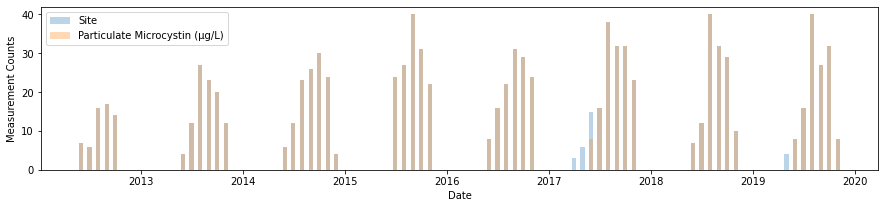

In [26]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Particulate Microcystin (µg/L)'])

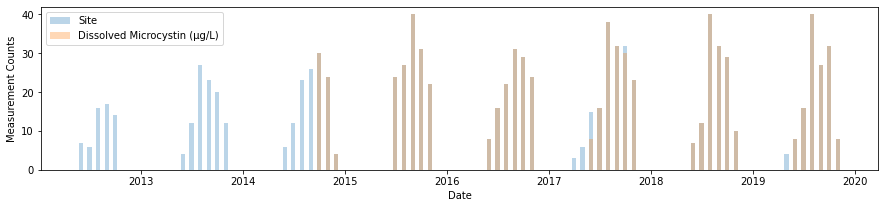

In [27]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Dissolved Microcystin (µg/L)'])

The particulate microcystin data is fairly complete, with most missing values located early in the season (March - May 2017 and April 2019). Dissolved microcystin data by contrast was not sampled until the middle of the 2014 season, after which it is mostly complete with some missing measurements in early 2017 and early 2019, similar to the particulate microcystin. This suggests that particulate microcystin might be a more complete target value if we intend to use the pre-2015 data. 

### Temperature Date Distribution
The quantities that are expected to have the most impact on algae growth are water temperature and the presence of nutrients such as phosphorus- and nitrogen-containing compounds, so we will also examine their date distributions.

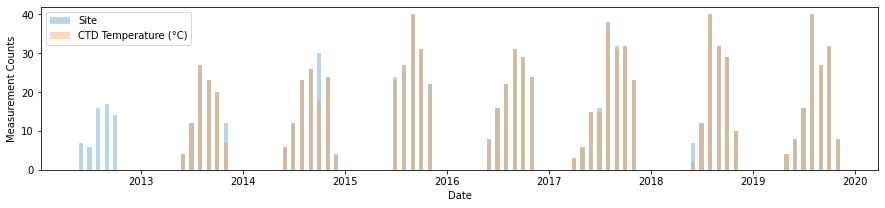

In [28]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'CTD Temperature (°C)'])

The temperature data is fairly complete after 2013 with some missing values for Oct 2013, Sept 2014 and May 2018. Temperature moreso than some other quantities may be logically calculated from other data for that month. As an example let's take a look at the temperature data for Oct 2013 and Sept 2014.

In [29]:
months = surface['Date'].apply(lambda d: d.month)
years = surface['Date'].apply(lambda d: d.year)
display(surface[(months == 10) & (years == 2013)][['CTD Temperature (°C)']].describe())
display(surface[(months == 9) & (years == 2014)][['CTD Temperature (°C)']].describe())

,CTD Temperature (°C)
count,7.000000
mean,14.785714
std,2.134189
min,12.100000
25%,13.100000
50%,15.100000
75%,16.250000
max,17.600000


,CTD Temperature (°C)
count,18.000000
mean,19.166667
std,1.038098
min,16.900000
25%,18.400000
50%,19.350000
75%,19.850000
max,20.900000


The monthly standard deviation for temperature seems to be in the range of 1-2°C, so it should be reasonable to interpolate missing temperature data using the montly median, or an average of the two nearest dates. It is less clear how to handle the missing 2012 data. Let's see the variation in temperature for a given month from year to year.

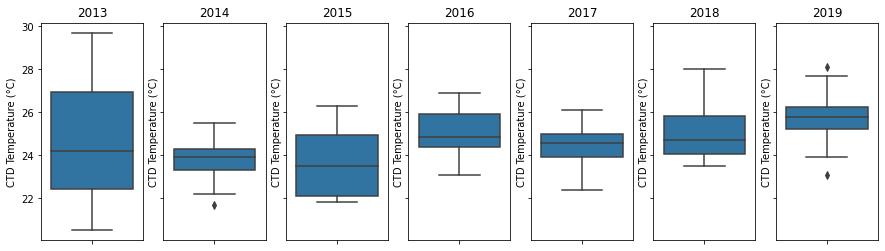

In [30]:
#July temps
fig, ax = plt.subplots(1, 7, figsize=(15,4), sharey=True)
for i, y in enumerate(range(2013, 2020)):
    seaborn.boxplot(surface[(months == 7) & (years == y)]['CTD Temperature (°C)'], ax=ax[i], orient='v')
    ax[i].set_title(y)

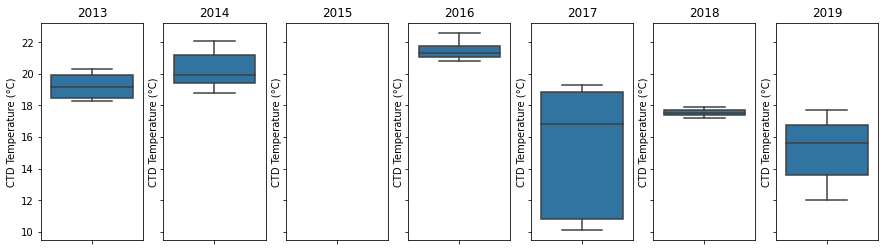

In [31]:
#May temps
fig, ax = plt.subplots(1, 7, figsize=(15,4), sharey=True)
for i, y in enumerate(range(2013, 2020)):
    seaborn.boxplot(surface[(months == 5) & (years == y)]['CTD Temperature (°C)'], ax=ax[i], orient='v')
    ax[i].set_title(y)

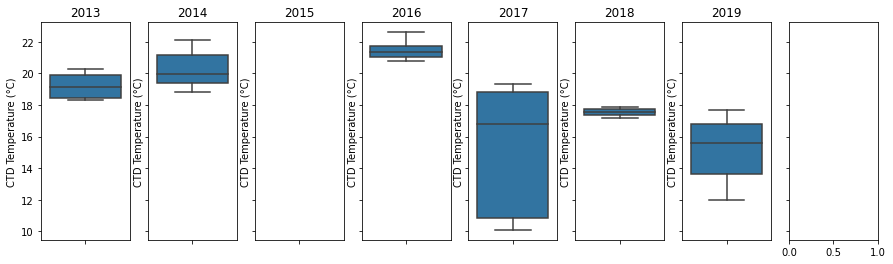

In [32]:
#August temps
fig, ax = plt.subplots(1, 8, figsize=(15,4), sharey=True)
for i, y in enumerate(range(2013, 2020)):
    seaborn.boxplot(surface[(months == 5) & (years == y)]['CTD Temperature (°C)'], ax=ax[i], orient='v')
    ax[i].set_title(y)

There is quite a bit of variation in some monthly temperature distributions from year to year. As expected it does not seem accurate to base one year's temperature on another year's temperature, since we would expect that variation to be influential in explaining the difference in HAB formation from year to year. If we want to obtain temperature data for 2012 we should obtain it from other data sources.

Let's fill in the missing temperature data for dates after 2012 using the monthly average.

In [33]:
null_temps = surface[surface['CTD Temperature (°C)'].isnull()]
for i in null_temps.index:
    month = null_temps.loc[i, 'Date'].month
    year = null_temps.loc[i, 'Date'].year
    same_month = surface[~surface['CTD Temperature (°C)'].isnull() & 
                         (months == month) & (years == year)]
    avg = same_month['CTD Temperature (°C)'].mean()
    surface.loc[i, 'CTD Temperature (°C)'] = avg

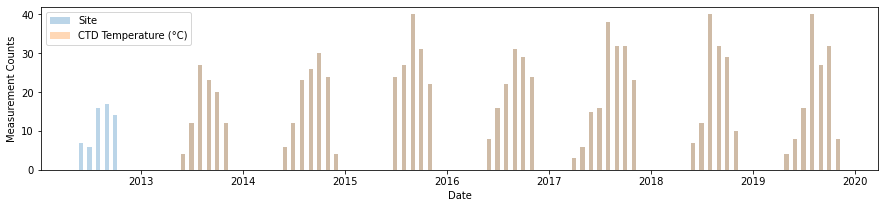

In [34]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'CTD Temperature (°C)'])

### Nitrogen and Phosphorus Date Distributions

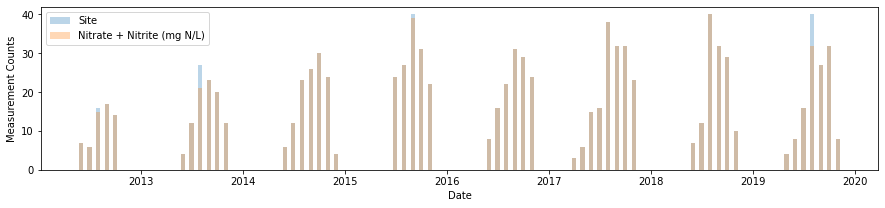

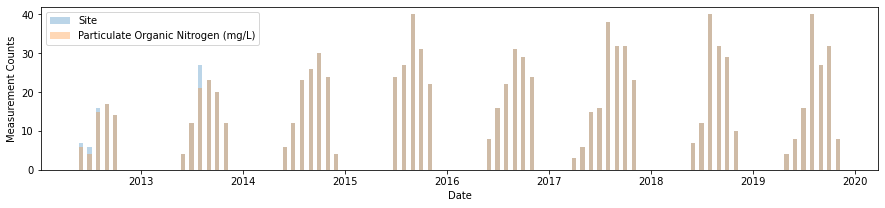

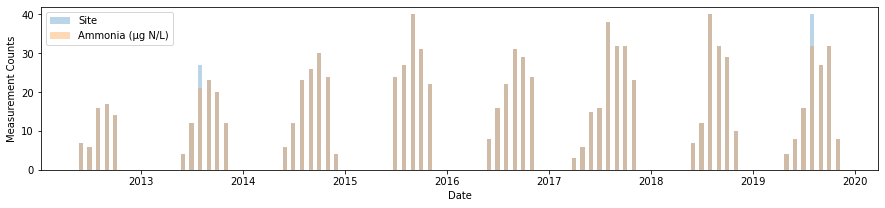

In [35]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Nitrate + Nitrite (mg N/L)'])
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Particulate Organic Nitrogen (mg/L)'])
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Ammonia (µg N/L)'])

The nitrogen data is fairly consistent and complete across time. There seem to be some missing values in July 2013 and July 2019. 

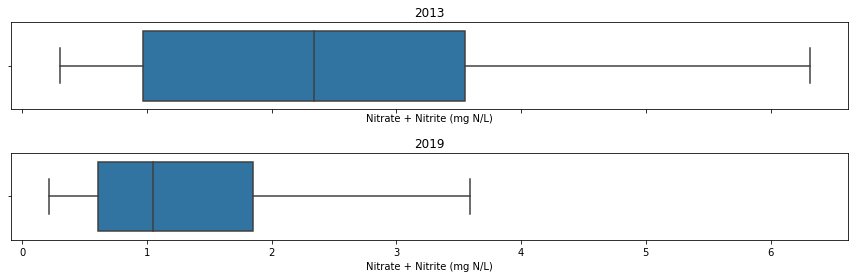

In [36]:
#July NOx data 
fig, ax = plt.subplots(2, 1, figsize=(15,4), sharex=True)
plt.subplots_adjust(hspace=0.5)
for i, y in enumerate([2013, 2019]):
    seaborn.boxplot(surface[(months == 7) & (years == y)]['Nitrate + Nitrite (mg N/L)'], ax=ax[i], orient='h')
    ax[i].set_title(y)

There doesn't seem to be a reliable pattern by month for all samples here. Let's plot by date.

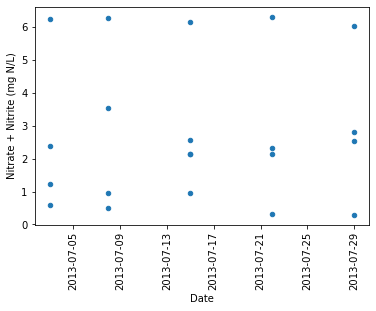

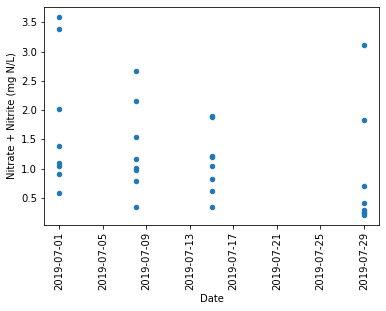

In [37]:
#Scatterplots of NOx by date for Jul 2013 and 2019
surface[(months == 7) & (years == 2013)].plot(kind='scatter', x='Date', y='Nitrate + Nitrite (mg N/L)', rot=90)
surface[(months == 7) & (years == 2019)].plot(kind='scatter', x='Date', y='Nitrate + Nitrite (mg N/L)', rot=90)

There does not seem to be a reliable pattern here - these values likely depend strongly on location. Unless we first aggregate within a coordinate grid we will likely have to drop the null values.

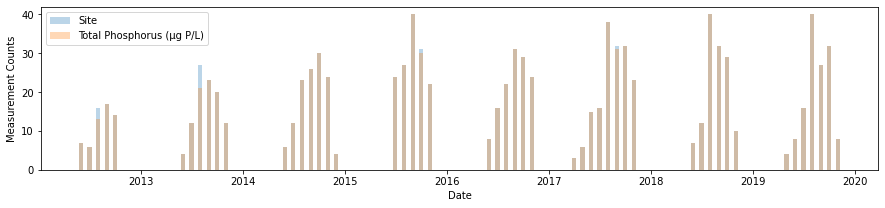

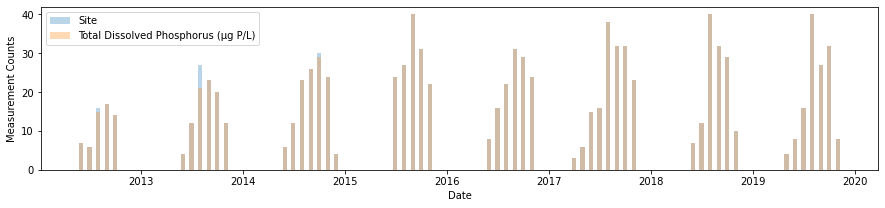

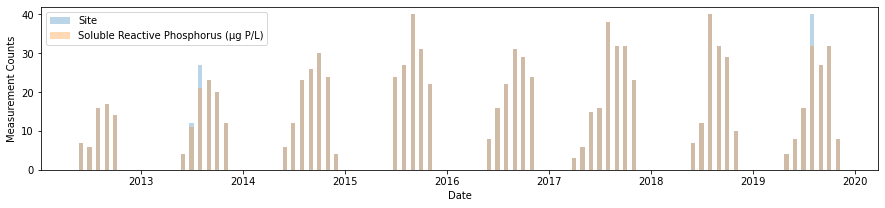

In [38]:
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Total Phosphorus (µg P/L)'])
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Total Dissolved Phosphorus (µg P/L)'])
resampled_counts(surface, 'Date', alpha=0.3, cols=['Site', 'Soluble Reactive Phosphorus (µg P/L)'])

The phosphorus data is fairly complete and consistent across time, similar to the nitrogen data.

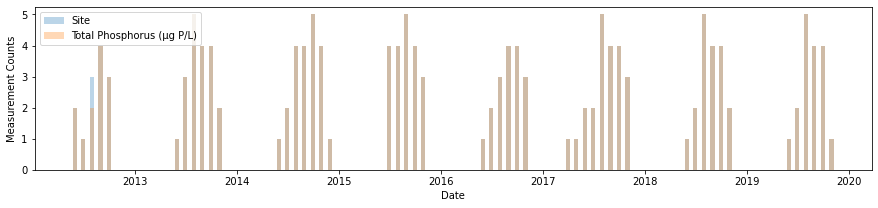

In [39]:
resampled_counts(surface[surface['Site'] == 'WE6'], 'Date', alpha=0.3, cols=['Site', 'Total Phosphorus (µg P/L)'])

In [40]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987 entries, 0 to 986
Data columns (total 33 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           987 non-null    datetime64[ns]
 1   Site                                                           987 non-null    object        
 2   Station Depth (m)                                              977 non-null    float64       
 3   Sample Depth (m)                                               987 non-null    float64       
 4   Sample Depth (category)                                        987 non-null    object        
 5   Local Time (Eastern Time Zone)                                 981 non-null    object        
 6   Latitude (decimal deg)                                         987 non-null    float64       
 7  

## Value Distributions

### Microcystin

In [41]:
def hist_zoom(df, col, cutoff=None, bins=None):
    ''' Displays a histogram of an entire column next to a histogram of all values below a 
    certain cutoff. If no cutoff is specified only the total histogram is shown.'''
    if cutoff == None:
        figsize=(15,3)
        plt.hist(df[col], bins=bins)
        plt.title(col)
    else:
        fig, ax = plt.subplots(1, 2, figsize=(15,3))
        ax[0].hist(df[col], bins=bins)
        ax[0].set_title('Total Distribution')
        filter_df = df[df[col] < cutoff]
        ax[1].hist(filter_df[col], bins=bins)
        ax[1].set_title('Partial Distribution - Zoom')
        fig.suptitle(col, fontsize=14)

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


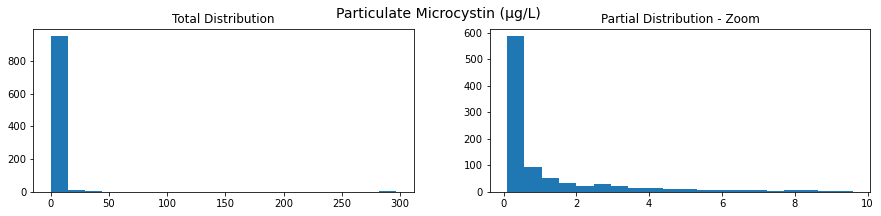

In [42]:
hist_zoom(surface, 'Particulate Microcystin (µg/L)', 10, bins=20)

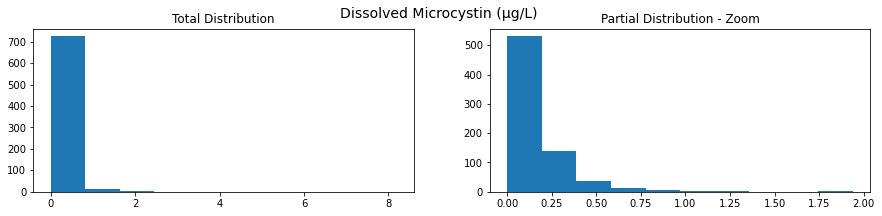

In [43]:
hist_zoom(surface, 'Dissolved Microcystin (µg/L)', 2)

In [44]:
#label data by month to generate box plots for each month
surface['Month'] = surface['Date'].dt.strftime('%y-%b')
surface = surface.sort_values('Date')

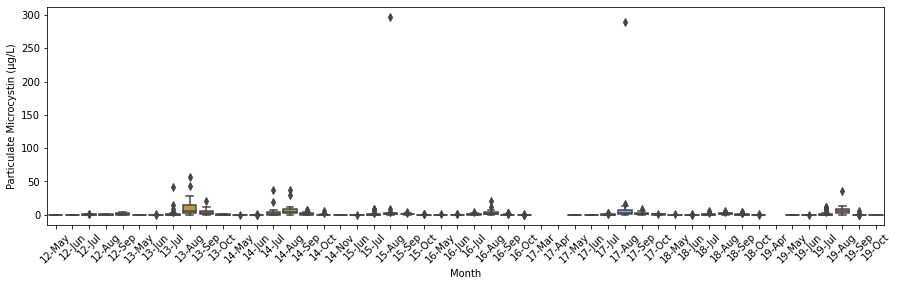

In [45]:
#plot monthly boxplots
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month',y='Particulate Microcystin (µg/L)',data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

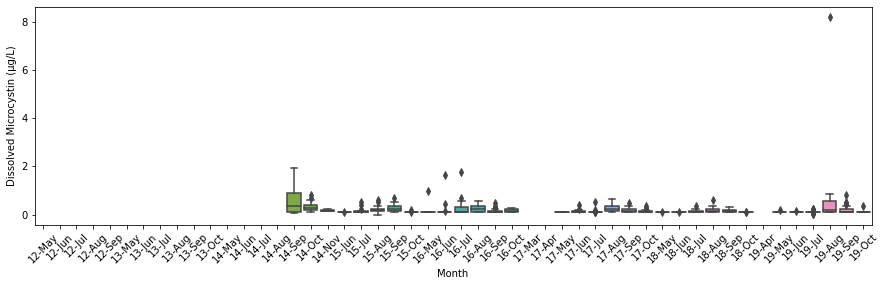

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month',y='Dissolved Microcystin (µg/L)',data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Both particulate and dissolved microcystin have most values clustered at zero, with long tail to the right. Particulate microcystin tends to have higher values than dissolved microcystin, which is simply a property of microcystin's solubility. In terms of reference values for microcystin, the Ohio EPA has a drinking level limit of 1.6 ug/L, a recreational limit of 6 ug/L for swimming and a strict no contact advisory for levels over 20 ug/L. There appear to be a few hundred samples with particulate microcystin levels over the drinking limit.

In terms of the microcystin measurements over time there is generally greater variability in 'peak' months later in the summer season, along with higher outliers and upper bounds. 

### Nitrogen, Nitrites and Nitrates (NOx)

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


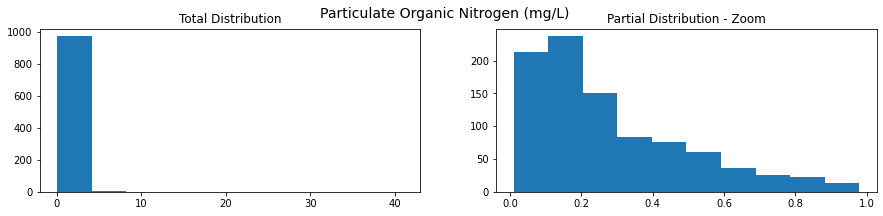

In [47]:
hist_zoom(surface, 'Particulate Organic Nitrogen (mg/L)', 1)

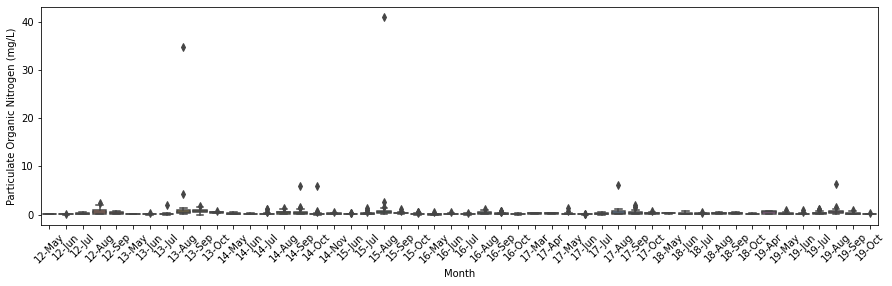

In [48]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Particulate Organic Nitrogen (mg/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


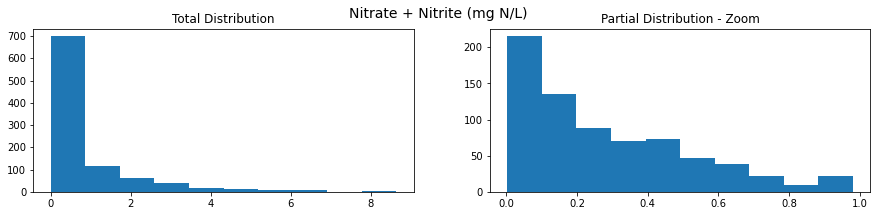

In [49]:
hist_zoom(surface, 'Nitrate + Nitrite (mg N/L)', 1)

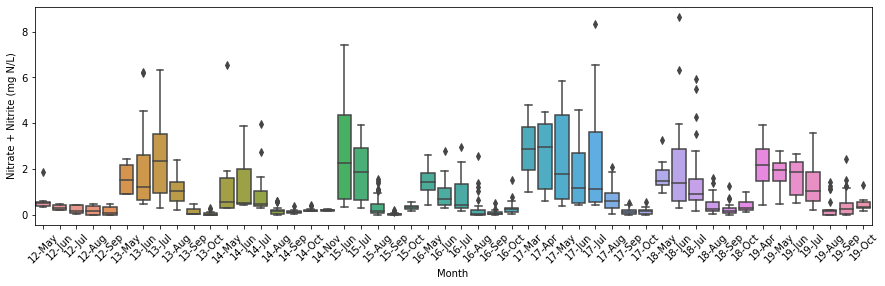

In [50]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Nitrate + Nitrite (mg N/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


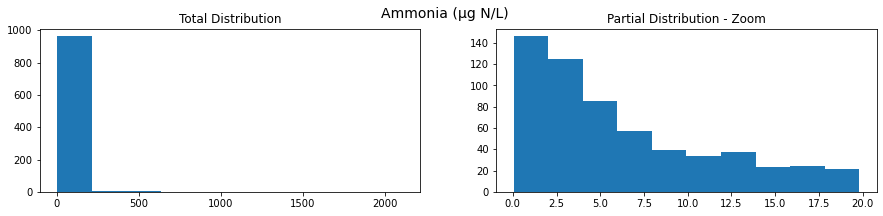

In [51]:
hist_zoom(surface, 'Ammonia (µg N/L)', 20)

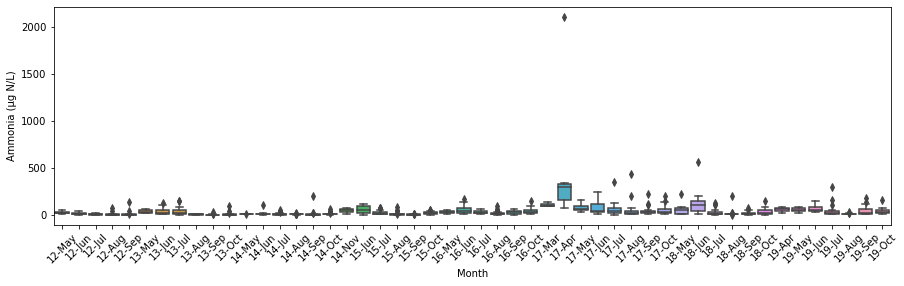

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Ammonia (µg N/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

All forms of nitrogen have a long right tail. In the Great Lakes algal growth is commonly thought to be phosphorus-limited, that is there is usually enough nitrogen to support the start of a bloom, but once the bloom begins and starts consuming the available nitrogen its growth may become nitrogen-limited. There is some debate as to whether reducing nitrogen levels in Lake Erie would be beneficial. <a href='https://www.umass.edu/mwwp/resources/factsheets.html'>UMass Amherst</a> suggests that if inorganic forms of nitrogen, including nitrate and ammonium (NH4+) exceed 0.3 mg/l in the spring then there is sufficient nitrogen to support a bloom come summer. We can clearly see there is a long tail of nitrate and nitrite above 0.3 mg/L. 

Nitrogen compounds interestingly tend to have higher concentrations and greater variability in the spring months. This could be consistent with the notion that as algae and other organisms grow in the warmer months they consume more and more nitrogenous compounds.

### Phosphorus-containing Compounds

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


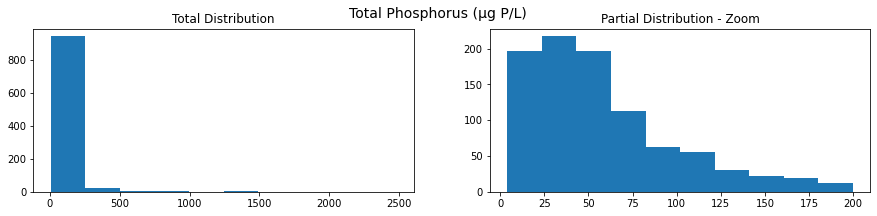

In [53]:
hist_zoom(surface, 'Total Phosphorus (µg P/L)', 200)

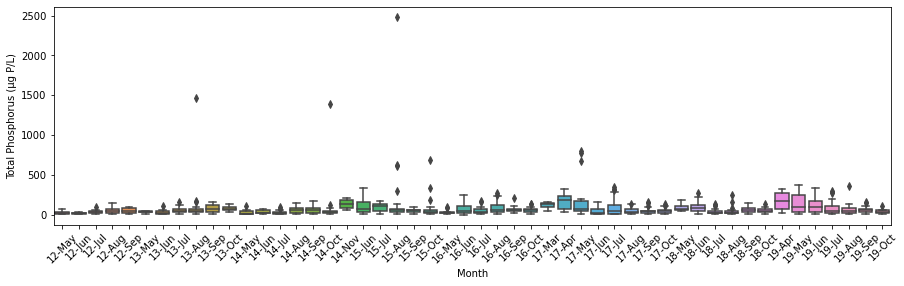

In [54]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Total Phosphorus (µg P/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


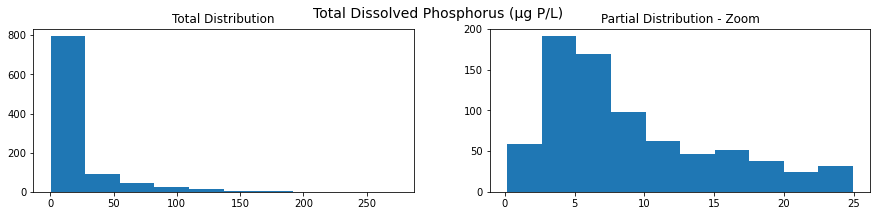

In [55]:
hist_zoom(surface, 'Total Dissolved Phosphorus (µg P/L)', 25)

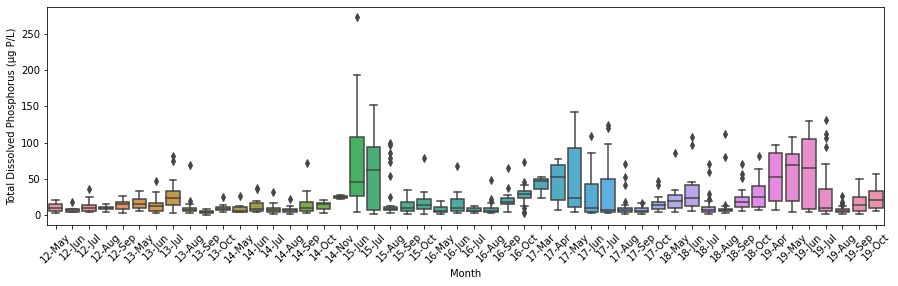

In [56]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Total Dissolved Phosphorus (µg P/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


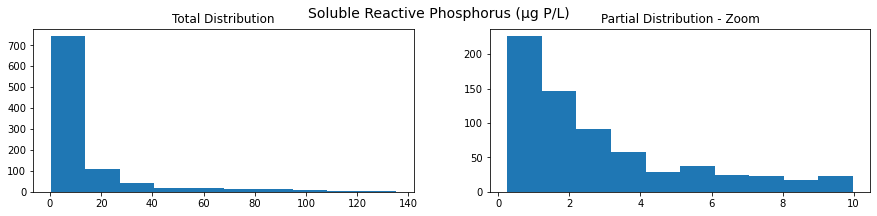

In [57]:
hist_zoom(surface, 'Soluble Reactive Phosphorus (µg P/L)', 10)

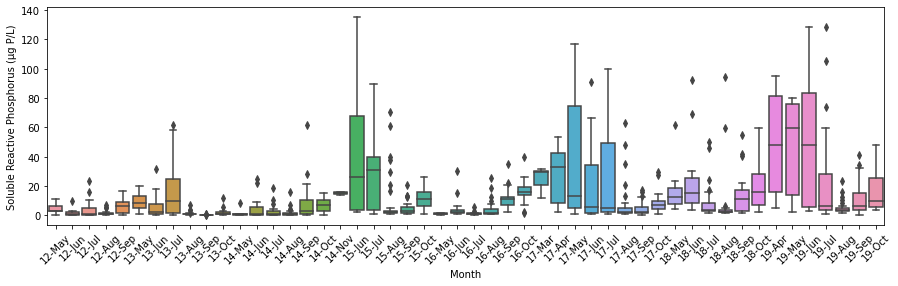

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='Soluble Reactive Phosphorus (µg P/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

The phosphorus distribution also has a long right tail. Total phosphorus is clustered around the 5-70 ug/L range, while total dissolved has its peak around 3-8 ug/L and soluble reactive phosphorus is around 0.5-1 ug/L. The <a href='https://www.epa.gov/sites/production/files/2015-10/documents/status-nutrients-lake-erie-basin-2010-42pp.pdf'>2008 Lake Erie Management Plan</a> cited a desired ecological endpoint of <15 ug/L of total phosphorus for the Western Basin of the lake, as an annual average. 

Phosphorus compounds seem to follow similar trends to nitrogen compounds over time. They tend to reach lows in late summer, with higher values in spring/early summer and sometimes recovering to high values in fall months. This again could suggest that organisms that fluorish in the summer months are consuming the phosphorus, leading to lower readings at that time.

## Conductivity-Temperature-Depth (CTD) Measurements

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


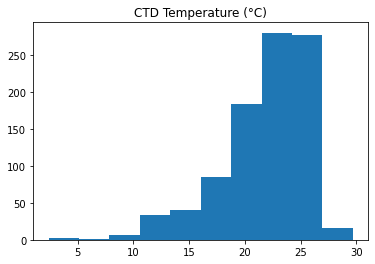

In [59]:
hist_zoom(surface, 'CTD Temperature (°C)')

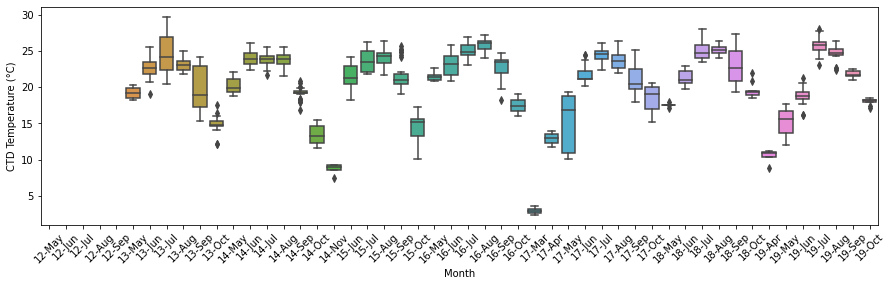

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='CTD Temperature (°C)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

The temperature distribution is left-skewed which is interesting, but logical due to the fact that most measurements are taken during the summer months, and therefore warmer temperatures. It is also logical that there seems to be a sharp drop above 26°C due to the nature of evaporative cooling. Once a certain temperature is reached (25 to 30°C) it takes a larger energetic input to raise the lake temperature due to increase evaporation and cooling. 

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


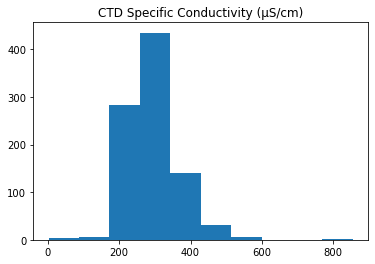

In [61]:
hist_zoom(surface, 'CTD Specific Conductivity (µS/cm)')

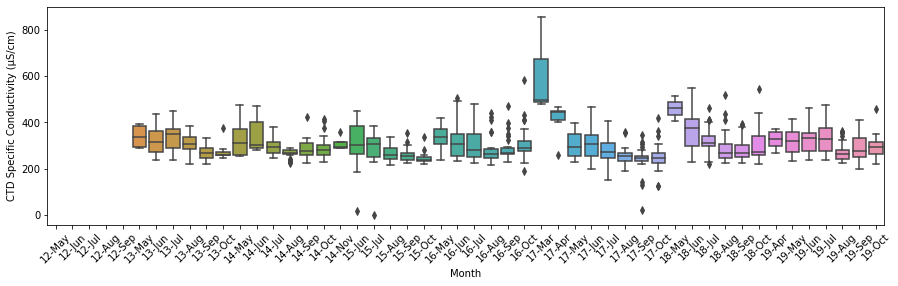

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='CTD Specific Conductivity (µS/cm)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

From the <a href='https://archive.epa.gov/water/archive/web/html/vms59.html#:~:text=The%20basic%20unit%20of%20measurement,0.5%20to%203%20%C2%B5mhos%2Fcm.'>EPA website</a>: "Distilled water has a conductivity in the range of 0.5 to 3 µmhos/cm. The conductivity of rivers in the United States generally ranges from 50 to 1500 µmhos/cm. Studies of inland fresh waters indicate that streams supporting good mixed fisheries have a range between 150 and 500 µmhos/cm. Conductivity outside this range could indicate that the water is not suitable for certain species of fish or macroinvertebrates. Industrial waters can range as high as 10,000 µmhos/cm."

It seems these values are all possible, with the bulk of them within the more expected range of 200 to 400 umhos/cm. It also seems that conductivity tends to be highest in early months (March-June) and then drops throughout the summer. 

/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/melanierbutler/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


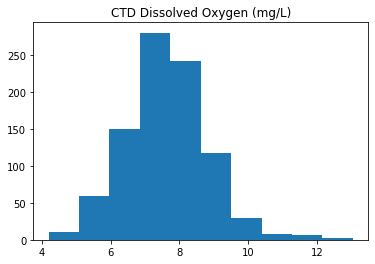

In [63]:
hist_zoom(surface, 'CTD Dissolved Oxygen (mg/L)')

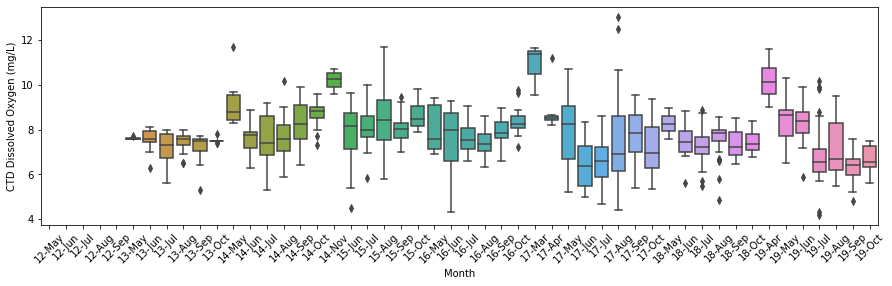

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(x='Month', y='CTD Dissolved Oxygen (mg/L)', data=surface, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Similar to the nutrients, dissolved oxygen tends to start higher in early months, reach a low point in midsummer (July/August) and sometimes recovers in later months (October).

## GLERL Phosphate Data

GLERL started collecting phosphate data in 2014 at four different sites - WE2, WE4, WE8, and WE13. These data are stored separately with hourly records. Here the phosphate measurements are collected into a single dataframe and examined.

In [65]:
#Create list of all phosphate csv files using glob 
PATH = "../data/raw"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT)) if re.search('phosphate', file, re.IGNORECASE)]
print(all_csv_files)
print(len(all_csv_files))

['../data/raw/0194301/1.1/data/0-data/WE08_2014_annual_summary_phosphate.csv', '../data/raw/0194301/1.1/data/0-data/WE08_2017_annual_summary_phosphate.csv', '../data/raw/0194301/1.1/data/0-data/WE08_2016_annual_summary_phosphate.csv', '../data/raw/0194301/1.1/data/0-data/WE08_2018_annual_summary_phosphate.csv', '../data/raw/0194301/1.1/data/0-data/WE08_2015_annual_summary_phosphate.csv', '../data/raw/0190201/1.1/data/0-data/WE02_2015_annual_summary_phosphate.csv', '../data/raw/0190201/1.1/data/0-data/WE02_2018_annual_summary_phosphate.csv', '../data/raw/0190201/1.1/data/0-data/WE02_2016_annual_summary_phosphate.csv', '../data/raw/0190201/1.1/data/0-data/WE02_2017_annual_summary_phosphate.csv', '../data/raw/0190201/1.1/data/0-data/WE02_2014_annual_summary_phosphate.csv', '../data/raw/0190729/1.1/data/0-data/WE04_2014_annual_summary_phosphate.csv', '../data/raw/0190729/1.1/data/0-data/WE04_2017_annual_summary_phosphate.csv', '../data/raw/0190729/1.1/data/0-data/WE04_2018_annual_summary_p

In [67]:
phosphate = pd.DataFrame()

for file in all_csv_files:
    #get site and year info from the file path, get longitude and latitude from the supporting lonlat.txt file
    site = os.path.split(file)[1].split('_')[0]
    file_num = os.path.split(file)[0].split('/')[3]
    coords_path = '../data/raw/' + file_num + '/1.1/about/' + file_num + '_lonlat.txt'
    with open(coords_path) as f:
        coords = f.readline()
    lon, lat = coords.strip().split(' ')
    
    #open df for particular site / year and parse dates, remove phosphate values below 0
    df = pd.read_csv(file, header=0)
    df = df.drop(index=[0,1]).reset_index(drop=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df['phosphate'] = df['phosphate'].astype('float')
    df = df.loc[df['phosphate'] >= 0]
    
    #add in site, longitude, latitude, and resample by day
    df['Site'] = site
    df['Longitude (decimal deg)'] = float(lon)
    df['Latitude (decimal deg)'] = float(lat)
    df = df.rename(columns={'timestamp' : 'Date', 'phosphate':'Phosphate (µg/L)'})
    df = df.resample('D', on='Date').apply({'Phosphate (µg/L)':'mean', 
                                            'Longitude (decimal deg)':'first', 
                                            'Latitude (decimal deg)':'first', 'Site':'first'})
    
    #append df for this site / year on to phosphate df 
    df.reset_index(inplace=True)
    phosphate = phosphate.append(df).reset_index(drop=True)

In [68]:
display(phosphate.sample(10))
phosphate.info()

,Date,Phosphate (µg/L),Longitude (decimal deg),Latitude (decimal deg),Site
2179,2015-09-22,5.177778,-83.136,41.741,WE13
648,2015-07-27,46.842857,-83.330,41.762,WE02
1776,2018-09-11,5.393750,-83.193,41.827,WE04
154,2017-10-13,4.023077,-83.364,41.834,WE08
1738,2018-08-04,1.962500,-83.193,41.827,WE04
2243,2018-06-19,NaN,NaN,NaN,NaN
1822,2016-05-13,NaN,NaN,NaN,NaN
311,2016-10-23,15.050000,-83.364,41.834,WE08
1184,2017-07-21,51.137500,-83.330,41.762,WE02
1708,2018-07-05,2.018750,-83.193,41.827,WE04


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2489 entries, 0 to 2488
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     2489 non-null   datetime64[ns]
 1   Phosphate (µg/L)         2043 non-null   float64       
 2   Longitude (decimal deg)  2043 non-null   float64       
 3   Latitude (decimal deg)   2043 non-null   float64       
 4   Site                     2043 non-null   object        
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 97.4+ KB


In [69]:
#remove null values from empty rows in csv file
phosphate = phosphate.loc[~phosphate['Site'].isnull()]
phosphate['Site'].value_counts()

WE02    695
WE04    572
WE08    516
WE13    260
Name: Site, dtype: int64

In [70]:
#rename sites to be consistent with site names in surface df
phosphate.loc[phosphate['Site'] == 'WE02', 'Site'] = 'WE2'
phosphate.loc[phosphate['Site'] == 'WE04', 'Site'] = 'WE4'
phosphate.loc[phosphate['Site'] == 'WE08', 'Site'] = 'WE8'

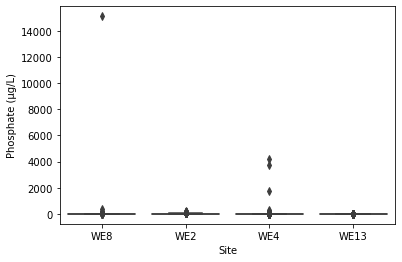

In [71]:
#examine values by site
fig, ax = plt.subplots()
seaborn.boxplot(data=phosphate, x='Site', y='Phosphate (µg/L)', ax=ax)

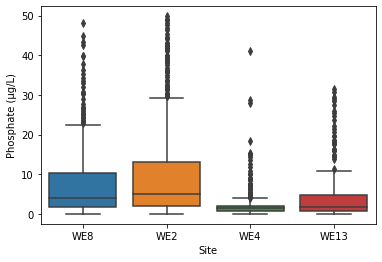

In [72]:
#there are some large outliers. select values to zoom in on data.
phosphate_mod = phosphate[phosphate['Phosphate (µg/L)'] < 50]
fig, ax = plt.subplots()
seaborn.boxplot(data=phosphate_mod, x='Site', y='Phosphate (µg/L)', ax=ax)
plt.show()

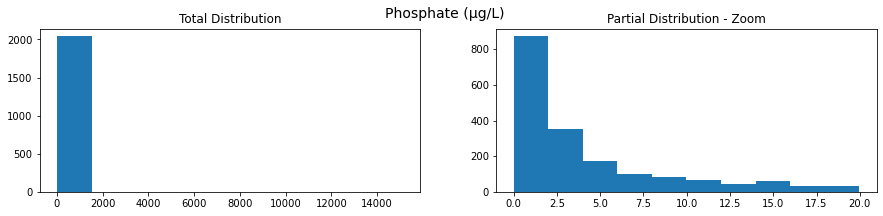

In [73]:
hist_zoom(phosphate, 'Phosphate (µg/L)', cutoff=20)

In [74]:
#create month column so boxplots can be shown over time by month.
phosphate['Month'] = phosphate['Date'].dt.strftime('%y-%b')
phosphate = phosphate.sort_values('Date')

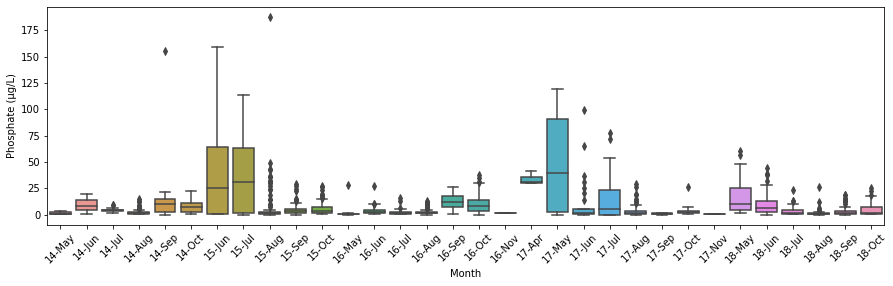

In [75]:
#again set a cutoff so plots are easier to see without outliers
phosphate_mod = phosphate[phosphate['Phosphate (µg/L)'] < 200]
fig, ax = plt.subplots()
fig.set_size_inches((15,4))
seaborn.boxplot(data=phosphate_mod, x='Month', y='Phosphate (µg/L)', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

Phosphate seems to have a similar distribution of values to other phosphorus measurements. I was unable to find EPA guidance for phosphate specifically, but federal guidance is less than <a href='https://www.water-research.net/index.php/phosphates#:~:text=Phosphates%20are%20not%20toxic%20to,extremely%20high%20levels%20of%20phosphate.&text=3.,0.025%20mg%2FL%20for%20reservoirs.'>25 ug/L for reservoirs for TOTAL phosphorus</a>. Soluble reactive phosphate, which was already included in the GLERL data, is one type of phosphate called orthophosphate. This is the most bioavailable form of phosphate for algae. Other types of phosphates, such as organic phosphates (e.g. adenosine triphosphate, or ATP) and inorganic phosphates (e.g. metal phosphates such as calcium phosphate) may also be included in the general phosphate data. (<a href='http://www.ohiowea.org/docs/OWEA_Phosphorus_CSM.pdf'>ref</a>) Finally, similar to other phosphorus measurements phosphate tends to have lower values in midsummer (July/August).

Lastly the GLENDA phosphate data is added to the GLENDA surface data by averaging phosphate measurements for each site within three days of the surface datapoint.

In [76]:
for i in surface.index:
    site = surface.loc[i, 'Site']
    date = surface.loc[i, 'Date']
    tdelta = dt.timedelta(days=3)
    phos_match = phosphate.loc[(phosphate['Site'] == site) & 
                               (abs(phosphate['Date'] - date) < tdelta)]
    phos_avg = phos_match['Phosphate (µg/L)'].mean()
    surface.loc[i, 'Phosphate (µg/L)'] = phos_avg

In [77]:
surface.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 987 entries, 135 to 134
Data columns (total 35 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           987 non-null    datetime64[ns]
 1   Site                                                           987 non-null    object        
 2   Station Depth (m)                                              977 non-null    float64       
 3   Sample Depth (m)                                               987 non-null    float64       
 4   Sample Depth (category)                                        987 non-null    object        
 5   Local Time (Eastern Time Zone)                                 981 non-null    object        
 6   Latitude (decimal deg)                                         987 non-null    float64       
 7

Only four sites were measured starting in 2014, so there are many null values.

In [78]:
surface.columns

Index(['Date', 'Site', 'Station Depth (m)', 'Sample Depth (m)',
       'Sample Depth (category)', 'Local Time (Eastern Time Zone)',
       'Latitude (decimal deg)', 'Longitude (decimal deg)',
       'Wind speed (knots)', 'Wave Height (ft)', 'Sky', 'Secchi Depth (m)',
       'CTD Temperature (°C)', 'CTD Specific Conductivity (µS/cm)',
       'CTD Beam Attenuation (m-1)', 'CTD Tramission (%)',
       'CTD Dissolved Oxygen (mg/L)',
       'CTD Photosynthetically Active Radiation (µE/m2/s)', 'Turbidity (NTU)',
       'Particulate Microcystin (µg/L)', 'Dissolved Microcystin (µg/L)',
       'Extracted Phycocyanin (µg/L)', 'Extracted Chlorophyll a (µg/L)',
       'Total Phosphorus (µg P/L)', 'Total Dissolved Phosphorus (µg P/L)',
       'Soluble Reactive Phosphorus (µg P/L)', 'Ammonia (µg N/L)',
       'Nitrate + Nitrite (mg N/L)', 'Particulate Organic Carbon (mg/L)',
       'Particulate Organic Nitrogen (mg/L)',
       'Colored Dissolved Organic Material absorbance (m-1) at 400nm ',
       '